# 8. 비지도 학습
## 8.3 오토 인코더

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [3]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

In [4]:
class Flatten(torch.nn.Module): # 4D -> 2D로 계산하기
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1) # (배치 수, 채널 수, 이미지 너비, 이미지 높이) -> (배치 수, 채널 수*이미지 너비*이미지 높이)

class Deflatten(nn.Module): # 2D -> 4D로 계산하기

    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k
        
    def forward(self, x):
        s = x.size()
        
        # 벡터 사이즈 = 채널 수*이미지 너비*이미지 높이
        # 벡터 사이즈 = 채널 수*이미지 사이즈**2
        # 이미지 사이즈 = (벡터 사이즈//채널 수)**.5
        feature_size = int((s[1]//self.k)**.5) 
        
        return x.view(s[0],self.k,feature_size,feature_size) # (배치 수, 채널 수*이미지 너비*이미지 높이) -> (배치 수, 채널 수, 이미지 너비, 이미지 높이) 
    

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        k = 16
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2), 
                        nn.ReLU(), 
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(), 
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, 10), 
                        nn.ReLU()
        )
        
        # ConvTranspose2d
        # 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
        # 출력 된 벡터는 행렬 형태로 변환한다.
        self.decoder = nn.Sequential(
                        nn.Linear(10, 1024),
                        nn.ReLU(),
                        Deflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1),
                        nn.Sigmoid()
        )
    
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [5]:
model = Autoencoder().to(device)

In [6]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze()) # 1채널인 경우 2로 변환
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [7]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    cost = running_loss / len(trainloader)        
    
    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %(epoch + 1, cost))  


[1] loss: 0.065
[11] loss: 0.025
[21] loss: 0.021
[31] loss: 0.020
[41] loss: 0.019
[51] loss: 0.019


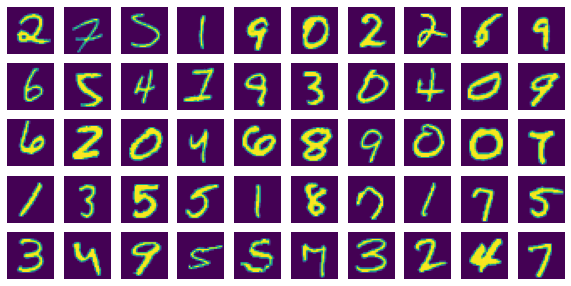

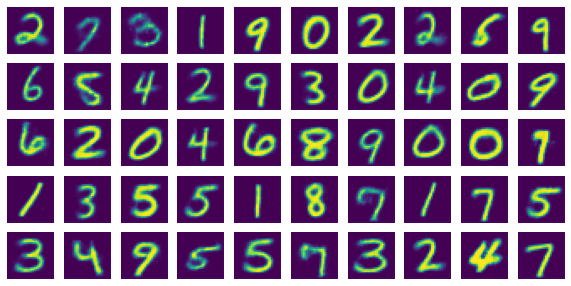

In [9]:
check_plot()